Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


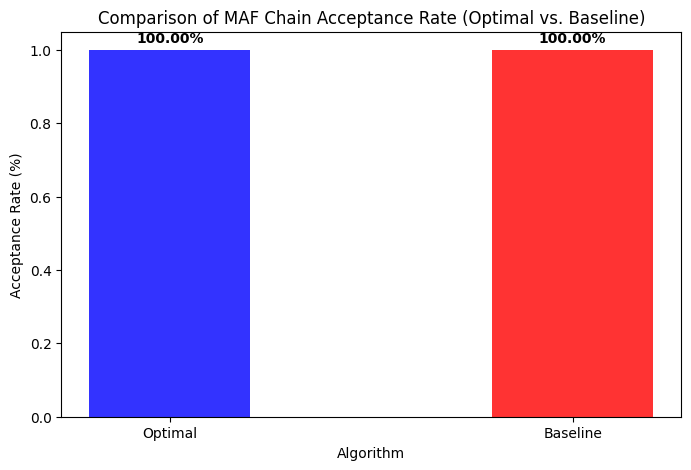

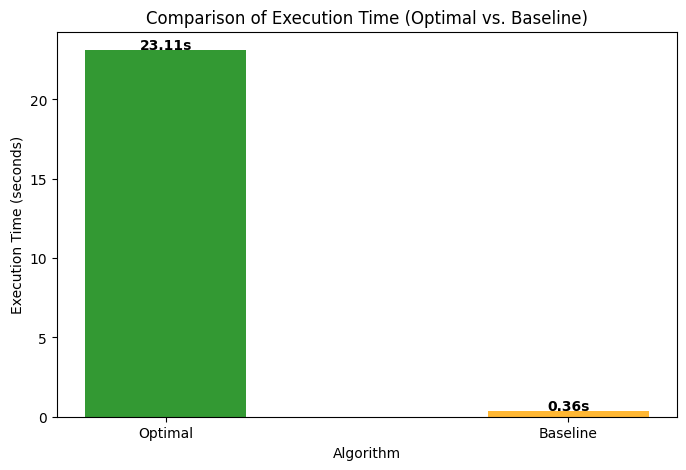

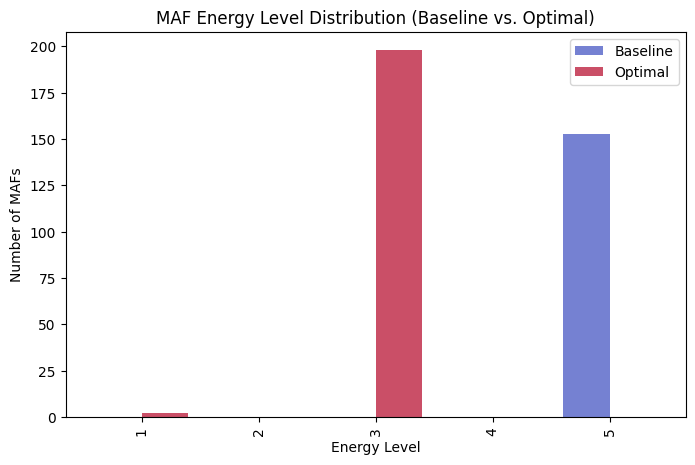

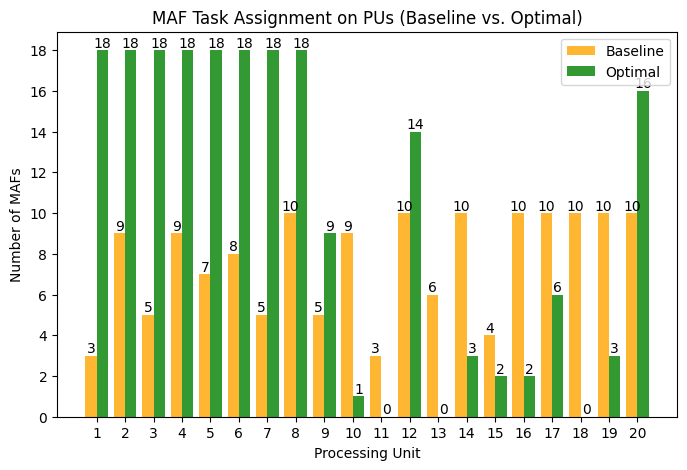

✅ Optimal Model Objective: 170594.00
✅ Baseline Model Objective: 121809.20


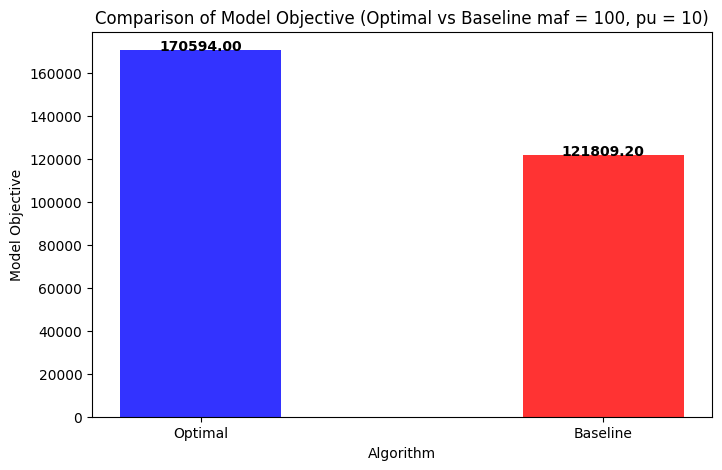

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 200  # Number of MAFs (tasks)
m = 20  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [500] * m  # Maximum energy consumption per processing unit
CPU_capacity = [700] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [100] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        # 计算任务链的端到端延迟（执行时间 + 通信延迟） Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        # 端到端（E2E）延迟约束（只有 `z_chain_k[k] = 1` 时生效）  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j] + (P_max[j] - P_idle[j]) * U_j[j] * T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=4, alpha_3=1, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        # 提取能耗级别
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  # 一旦找到能耗级别，就不需要继续检查其他级别
        
        # 提取PU分配（假设每个MAF只有一个分配）
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  # 一旦找到PU分配，就不需要继续检查其他PU
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

# calculate and store Acceptance Rate
acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
acceptance_rate_base = calculate_acceptance_rate(baseline_model)

acceptance_rates_opt.append(acceptance_rate_opt)
acceptance_rates_base.append(acceptance_rate_base)
execution_times_opt.append(execution_time_opt)
execution_times_base.append(execution_time_base)


# === Visualize MAF chain acceptance rate ===
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))

ax.bar(x, [acceptance_rate_opt, acceptance_rate_base], width=0.4, color=["blue", "red"], alpha=0.8)

ax.set_xlabel("Algorithm")
ax.set_ylabel("Acceptance Rate (%)")
ax.set_title("Comparison of MAF Chain Acceptance Rate (Optimal vs. Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
    ax.text(i, v + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()


# === Visualize Execution Time ===
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, [execution_time_opt, execution_time_base], width=0.4, color=["green", "orange"], alpha=0.8)

ax.set_xlabel("Algorithm")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Comparison of Execution Time (Optimal vs. Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

for i, v in enumerate([execution_time_opt, execution_time_base]):
    ax.text(i, v + 0.05, f"{v:.2f}s", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()


# === Visualize MAF Energy Level Distribution ===
fig, ax = plt.subplots(figsize=(8, 5))
energy_levels = np.arange(1, K + 1)

df_energy = pd.DataFrame({
    "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
    "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
})

df_energy.plot(kind="bar", figsize=(8, 5), width=0.8, colormap="coolwarm", alpha=0.7, ax=ax)

ax.set_xlabel("Energy Level")
ax.set_ylabel("Number of MAFs")
ax.set_title("MAF Energy Level Distribution (Baseline vs. Optimal)")
ax.set_xticks(range(K))
ax.set_xticklabels(energy_levels)
ax.legend(["Baseline", "Optimal"])
plt.show()


# === Visualize MAF Task Assignment on PUs ===
fig, ax = plt.subplots(figsize=(8, 5))

df_pu = pd.DataFrame({
    "PU": np.arange(1, m + 1),
    "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
    "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
})

bar_width = 0.4
x = np.arange(1, m + 1)


bars_baseline = ax.bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", label="Baseline", alpha=0.8)
bars_optimal = ax.bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", label="Optimal", alpha=0.8)
ax.set_xlabel("Processing Unit")
ax.set_ylabel("Number of MAFs")
ax.set_title("MAF Task Assignment on PUs (Baseline vs. Optimal)")
ax.set_xticks(np.arange(1, m + 1))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for bar in bars_baseline:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

for bar in bars_optimal:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

ax.legend()
plt.show()


# === Visualize Model Objective Comparison ===
optimal_obj = optimal_model.objVal if optimal_model else float('-inf')
baseline_obj = baseline_model.objVal if baseline_model else float('-inf')

print(f"✅ Optimal Model Objective: {optimal_obj:.2f}")
print(f"✅ Baseline Model Objective: {baseline_obj:.2f}")



fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))


ax.bar(x, [optimal_obj, baseline_obj], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Model Objective")
ax.set_title("Comparison of Model Objective (Optimal vs Baseline maf = 100, pu = 10)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([optimal_obj, baseline_obj]):
    ax.text(i, v + 5, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.show()




Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


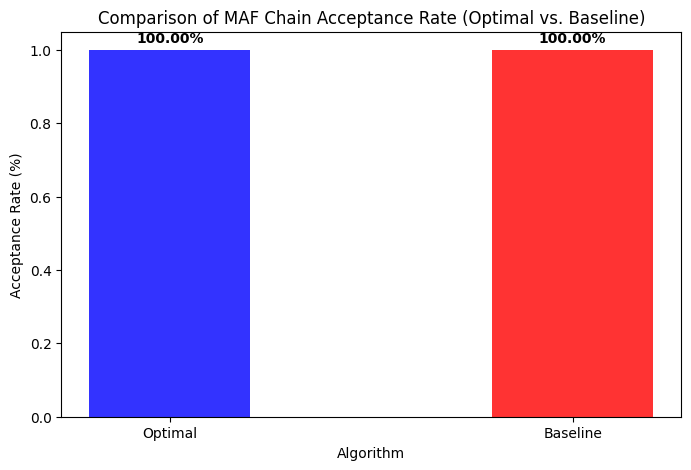

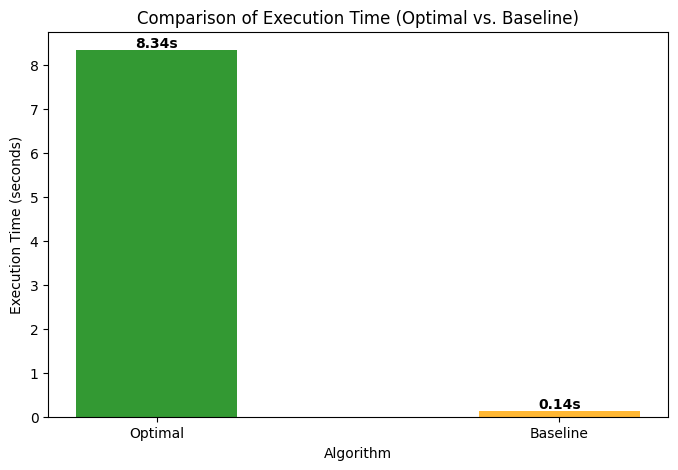

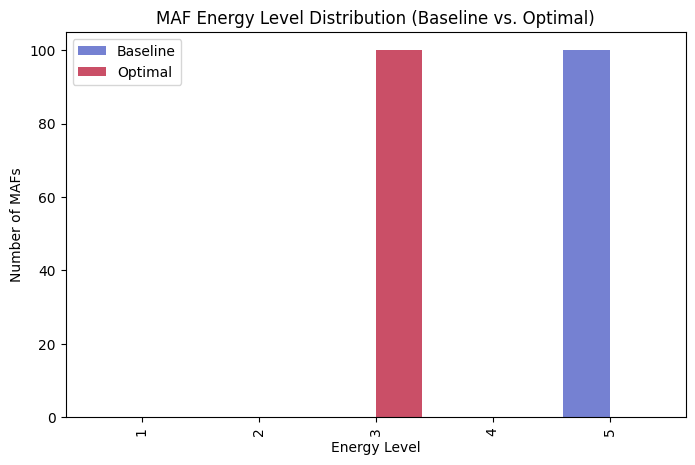

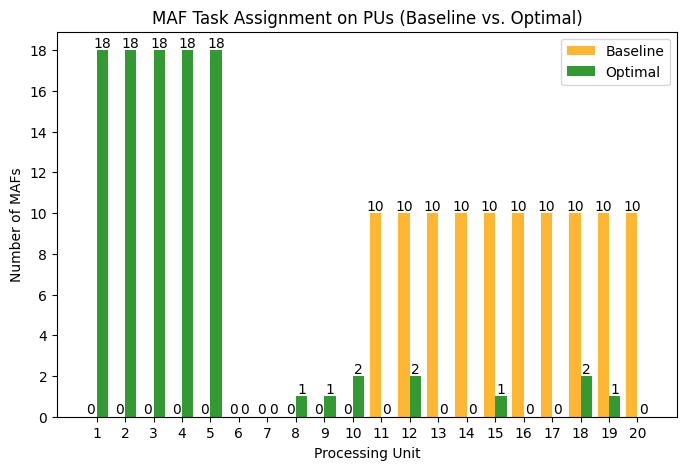

✅ Optimal Model Objective: 85520.00
✅ Baseline Model Objective: 84200.00


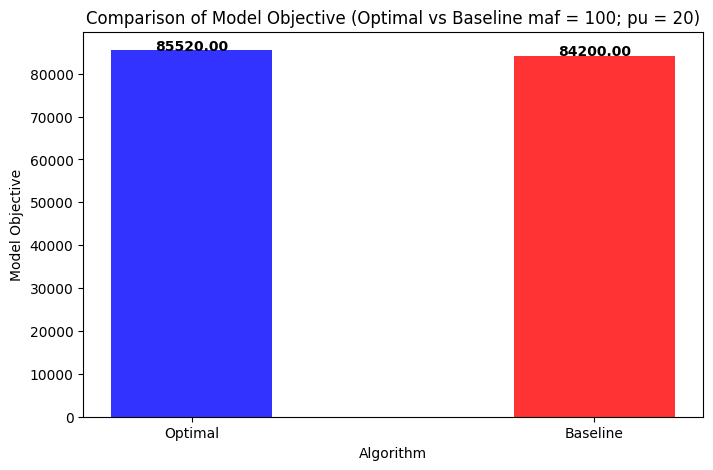

In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 20  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [500] * m  # Maximum energy consumption per processing unit
CPU_capacity = [700] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [80] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        # 计算任务链的端到端延迟（执行时间 + 通信延迟） Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        # 端到端（E2E）延迟约束（只有 `z_chain_k[k] = 1` 时生效）  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j] + (P_max[j] - P_idle[j]) * U_j[j] * T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        # 提取能耗级别
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  # 一旦找到能耗级别，就不需要继续检查其他级别
        
        # 提取PU分配（假设每个MAF只有一个分配）
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  # 一旦找到PU分配，就不需要继续检查其他PU
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

# calculate and store Acceptance Rate
acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
acceptance_rate_base = calculate_acceptance_rate(baseline_model)

acceptance_rates_opt.append(acceptance_rate_opt)
acceptance_rates_base.append(acceptance_rate_base)
execution_times_opt.append(execution_time_opt)
execution_times_base.append(execution_time_base)


# === Visualize MAF chain acceptance rate ===
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))

ax.bar(x, [acceptance_rate_opt, acceptance_rate_base], width=0.4, color=["blue", "red"], alpha=0.8)

ax.set_xlabel("Algorithm")
ax.set_ylabel("Acceptance Rate (%)")
ax.set_title("Comparison of MAF Chain Acceptance Rate (Optimal vs. Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
    ax.text(i, v + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()


# === Visualize Execution Time ===
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, [execution_time_opt, execution_time_base], width=0.4, color=["green", "orange"], alpha=0.8)

ax.set_xlabel("Algorithm")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Comparison of Execution Time (Optimal vs. Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

for i, v in enumerate([execution_time_opt, execution_time_base]):
    ax.text(i, v + 0.05, f"{v:.2f}s", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()


# === Visualize MAF Energy Level Distribution ===
fig, ax = plt.subplots(figsize=(8, 5))
energy_levels = np.arange(1, K + 1)

df_energy = pd.DataFrame({
    "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
    "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
})

df_energy.plot(kind="bar", figsize=(8, 5), width=0.8, colormap="coolwarm", alpha=0.7, ax=ax)

ax.set_xlabel("Energy Level")
ax.set_ylabel("Number of MAFs")
ax.set_title("MAF Energy Level Distribution (Baseline vs. Optimal)")
ax.set_xticks(range(K))
ax.set_xticklabels(energy_levels)
ax.legend(["Baseline", "Optimal"])
plt.show()


# === Visualize MAF Task Assignment on PUs ===
fig, ax = plt.subplots(figsize=(8, 5))

df_pu = pd.DataFrame({
    "PU": np.arange(1, m + 1),
    "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
    "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
})

bar_width = 0.4
x = np.arange(1, m + 1)


bars_baseline = ax.bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", label="Baseline", alpha=0.8)
bars_optimal = ax.bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", label="Optimal", alpha=0.8)
ax.set_xlabel("Processing Unit")
ax.set_ylabel("Number of MAFs")
ax.set_title("MAF Task Assignment on PUs (Baseline vs. Optimal)")
ax.set_xticks(np.arange(1, m + 1))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for bar in bars_baseline:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

for bar in bars_optimal:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

ax.legend()
plt.show()


# === Visualize Model Objective Comparison ===
optimal_obj = optimal_model.objVal if optimal_model else float('-inf')
baseline_obj = baseline_model.objVal if baseline_model else float('-inf')

print(f"✅ Optimal Model Objective: {optimal_obj:.2f}")
print(f"✅ Baseline Model Objective: {baseline_obj:.2f}")



fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))


ax.bar(x, [optimal_obj, baseline_obj], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Model Objective")
ax.set_title("Comparison of Model Objective (Optimal vs Baseline maf = 100; pu = 20)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([optimal_obj, baseline_obj]):
    ax.text(i, v + 5, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.show()

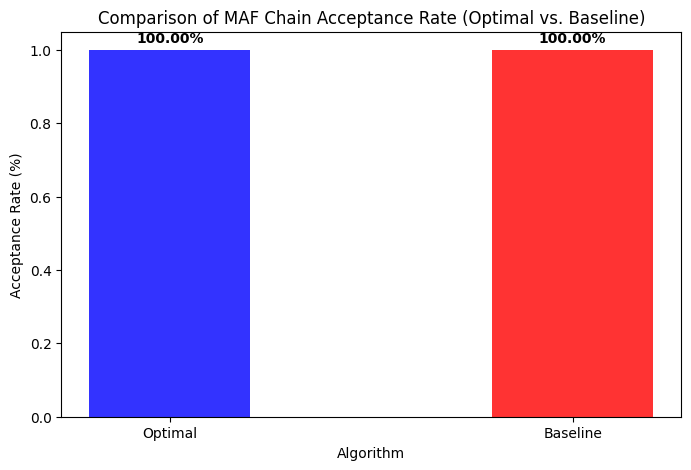

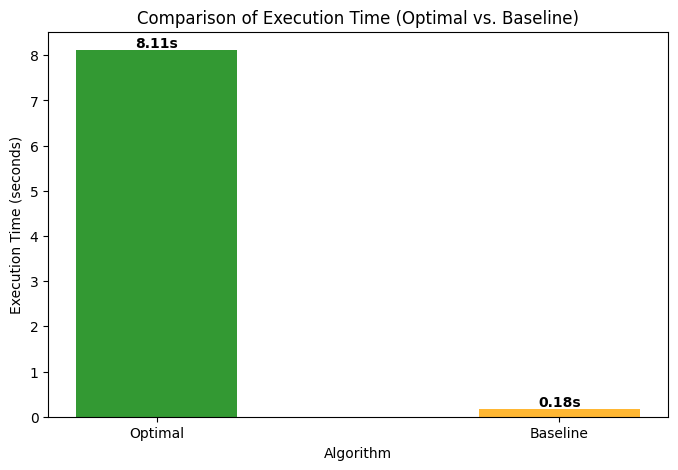

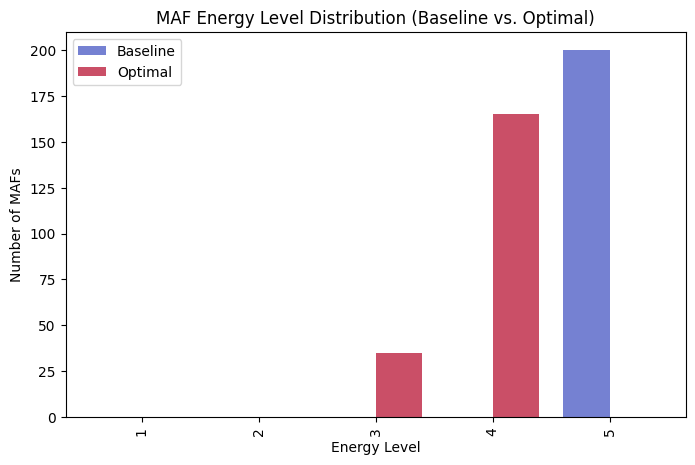

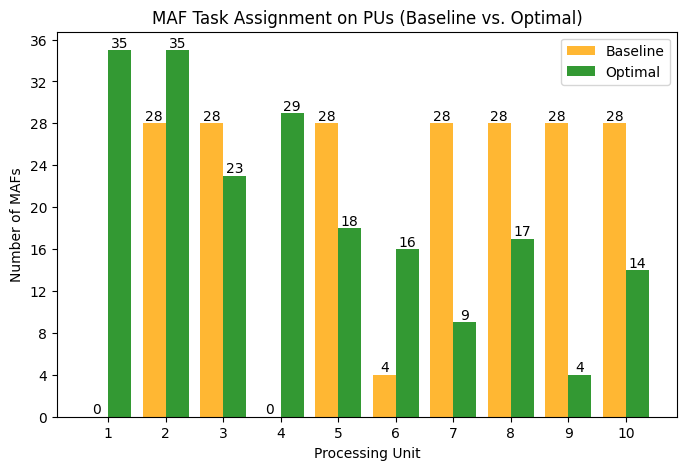

✅ Optimal Model Objective: 170962.00
✅ Baseline Model Objective: 168520.00


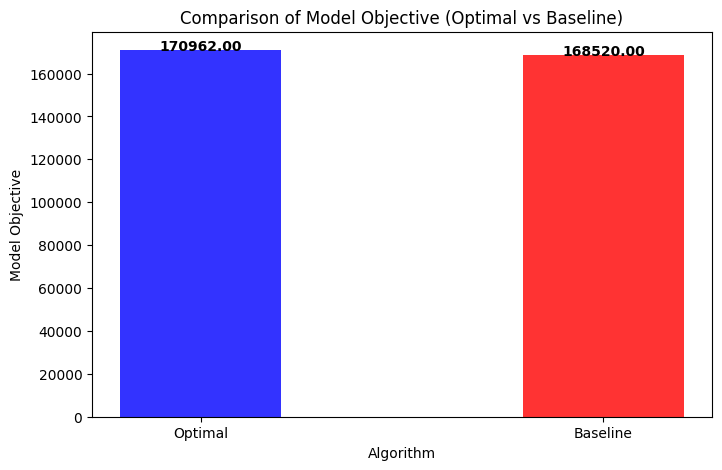

In [2]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display
from matplotlib.ticker import MaxNLocator

# === Problem Setup ===
n = 200  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [500] * m  # Maximum energy consumption per processing unit
CPU_capacity = [700] * m  # CPU resources per processing unit
f_v_levels = [5, 7,  10, 20, 25,  30, 65,80]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 8
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [70] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        # 计算任务链的端到端延迟（执行时间 + 通信延迟） Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        # 端到端（E2E）延迟约束（只有 `z_chain_k[k] = 1` 时生效）  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j] + (P_max[j] - P_idle[j]) * U_j[j] * T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    
    for i in range(n):
        # 提取能耗级别
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
                break  # 一旦找到能耗级别，就不需要继续检查其他级别
        
        # 提取PU分配（假设每个MAF只有一个分配）
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
                break  # 一旦找到PU分配，就不需要继续检查其他PU
    
    return maf_energy_levels, maf_pu_assignments


optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)



# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

# calculate and store Acceptance Rate
acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
acceptance_rate_base = calculate_acceptance_rate(baseline_model)

acceptance_rates_opt.append(acceptance_rate_opt)
acceptance_rates_base.append(acceptance_rate_base)
execution_times_opt.append(execution_time_opt)
execution_times_base.append(execution_time_base)


# === Visualize MAF chain acceptance rate ===
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))

ax.bar(x, [acceptance_rate_opt, acceptance_rate_base], width=0.4, color=["blue", "red"], alpha=0.8)

ax.set_xlabel("Algorithm")
ax.set_ylabel("Acceptance Rate (%)")
ax.set_title("Comparison of MAF Chain Acceptance Rate (Optimal vs. Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
    ax.text(i, v + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()


# === Visualize Execution Time ===
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, [execution_time_opt, execution_time_base], width=0.4, color=["green", "orange"], alpha=0.8)

ax.set_xlabel("Algorithm")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Comparison of Execution Time (Optimal vs. Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

for i, v in enumerate([execution_time_opt, execution_time_base]):
    ax.text(i, v + 0.05, f"{v:.2f}s", ha="center", fontsize=10, fontweight="bold", color="black")

plt.show()


# === Visualize MAF Energy Level Distribution ===
fig, ax = plt.subplots(figsize=(8, 5))
energy_levels = np.arange(1, K + 1)

df_energy = pd.DataFrame({
    "Baseline": np.bincount(baseline_energy_levels, minlength=K + 1)[1:],
    "Optimal": np.bincount(optimal_energy_levels, minlength=K + 1)[1:]
})

df_energy.plot(kind="bar", figsize=(8, 5), width=0.8, colormap="coolwarm", alpha=0.7, ax=ax)

ax.set_xlabel("Energy Level")
ax.set_ylabel("Number of MAFs")
ax.set_title("MAF Energy Level Distribution (Baseline vs. Optimal)")
ax.set_xticks(range(K))
ax.set_xticklabels(energy_levels)
ax.legend(["Baseline", "Optimal"])
plt.show()


# === Visualize MAF Task Assignment on PUs ===
fig, ax = plt.subplots(figsize=(8, 5))

df_pu = pd.DataFrame({
    "PU": np.arange(1, m + 1),
    "Baseline": np.bincount(baseline_pu_assignments, minlength=m + 1)[1:].astype(int),
    "Optimal": np.bincount(optimal_pu_assignments, minlength=m + 1)[1:].astype(int)
})

bar_width = 0.4
x = np.arange(1, m + 1)


bars_baseline = ax.bar(x - bar_width/2, df_pu["Baseline"], width=bar_width, color="orange", label="Baseline", alpha=0.8)
bars_optimal = ax.bar(x + bar_width/2, df_pu["Optimal"], width=bar_width, color="green", label="Optimal", alpha=0.8)
ax.set_xlabel("Processing Unit")
ax.set_ylabel("Number of MAFs")
ax.set_title("MAF Task Assignment on PUs (Baseline vs. Optimal)")
ax.set_xticks(np.arange(1, m + 1))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for bar in bars_baseline:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

for bar in bars_optimal:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=10)

ax.legend()
plt.show()


# === Visualize Model Objective Comparison ===
optimal_obj = optimal_model.objVal if optimal_model else float('-inf')
baseline_obj = baseline_model.objVal if baseline_model else float('-inf')

print(f"✅ Optimal Model Objective: {optimal_obj:.2f}")
print(f"✅ Baseline Model Objective: {baseline_obj:.2f}")



fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))


ax.bar(x, [optimal_obj, baseline_obj], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Model Objective")
ax.set_title("Comparison of Model Objective (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([optimal_obj, baseline_obj]):
    ax.text(i, v + 5, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.show()